In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

In [2]:
#import hotel reviews into a dataframe
df = pd.read_csv('yelp_reviews_filtered.csv')

### Prepare data for modeling

In [3]:
#create a label column that will be used for our model
def create_label(rating):
    if rating > 3:
        return 1
    elif rating == 3:
        return -1
    else:
        return 0

df['label'] = df.review_rating.apply(create_label)

In [4]:
#look at the breakdown of postive, neutral, and negative reviews
print(len(df[df.label==1]))
print(len(df[df.label==0]))
print(len(df[df.label==-1]))

25293
24798
11543


In [5]:
#remove 3 star reviews from dataset so we can focus on positive and negative classification
data = df[df.review_rating != 3]

In [6]:
from sklearn.model_selection import train_test_split

X = data.text
y = data.label

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

### Vectorize Text

In [7]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#create a function that pre_processes the text in our reviews
def pre_process(text):
    # Tokenize the article: tokens
    tokens = word_tokenize(text)

    # Convert the tokens into lowercase
    lower_tokens = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))

    # Retain alphabetic characters
    alpha_only = [t for t in lower_tokens if t.isalpha()]

    # Remove all stop words
    return [t  for t in alpha_only if t not in stop_words]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

#Initialize a CountVectorizer object, and use the pre_process function to clean the text
count_vectorizer = CountVectorizer(analyzer = pre_process, stop_words='english')

In [9]:
#Transform the training data 
count_train = count_vectorizer.fit_transform(X_train)

In [10]:
#Transform the testing data
count_test = count_vectorizer.transform(X_test)

In [11]:
# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['aa', 'aaa', 'aaaaaaaaaaaaawwwwwwwwwwwwww', 'aaaaaaaaaaaoooiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii', 'aaaaaaall', 'aaaaaand', 'aaaaah', 'aaaaahhh', 'aaaaand', 'aaaaanyway']


In [12]:
#Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer = pre_process, stop_words='english', max_df=0.7)

In [13]:
#Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [14]:
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)


### Multinomial Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

# Fit the classifier to training data
nb_classifier.fit(count_train, y_train)

# Create predictions
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

0.8978940013973451
[[4678  376]
 [ 647 4318]]


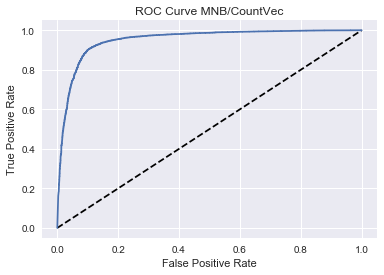

AUC:  0.9511143497159179


In [16]:
#Create ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_prob = nb_classifier.predict_proba(count_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve MNB/CountVec')
plt.show()


# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))


In [17]:
nb_classifier = MultinomialNB()

# Fit the classifier to training data
nb_classifier.fit(tfidf_train, y_train)

# Create predictions
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

0.9053797784210001
[[4643  411]
 [ 537 4428]]


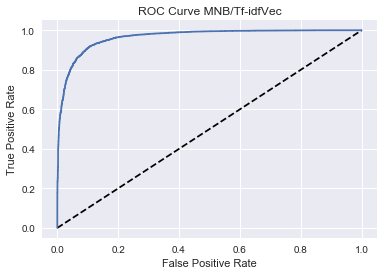

AUC:  0.9656269390282831


In [18]:
y_pred_prob = nb_classifier.predict_proba(tfidf_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve MNB/Tf-idfVec')
plt.show()


# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

#using count vectorizer
logreg = LogisticRegression()
logreg.fit(count_train, y_train)
y_pred = logreg.predict(count_test)
score = metrics.accuracy_score(y_test, y_pred)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
print(cm)

0.9239445054396647
[[4677  377]
 [ 385 4580]]


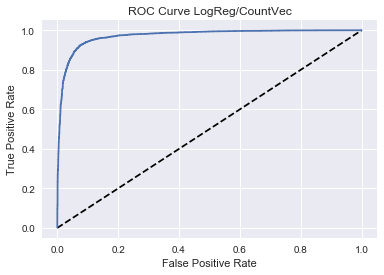

AUC:  0.9719062324279454


In [20]:
y_pred_prob = logreg.predict_proba(count_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LogReg/CountVec')
plt.show()


# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

In [21]:
#using tf-idf vectorizer
logreg = LogisticRegression()
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

score = metrics.accuracy_score(y_test, y_pred)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
print(cm)

0.9267391955284958
[[4678  376]
 [ 358 4607]]


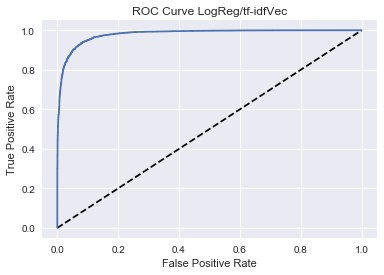

AUC:  0.9801481761328108


In [22]:
y_pred_prob = logreg.predict_proba(tfidf_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LogReg/tf-idfVec')
plt.show()


# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

### Tune parameters

In [23]:
#Create the list of alphas for MultinomialNB
alphas = [.3,.5,.7,.9]

#tune parameters for the count vectorizer 
def train_and_predict_cv(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(count_train, y_train)
    pred = nb_classifier.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict_cv(alpha))
    print()
    

Alpha:  0.3
Score:  0.8982932428386067

Alpha:  0.5
Score:  0.8977941910370296

Alpha:  0.7
Score:  0.8981934324782912

Alpha:  0.9
Score:  0.8980936221179758



In [24]:
#Create the list of alphas for MultinomialNB
alphas = [.3,.5,.7,.9]

#tune parameters for the tf-idf vectorizer 
def train_and_predict_tf(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict_tf(alpha))
    print()

Alpha:  0.3
Score:  0.9046811058987922

Alpha:  0.5
Score:  0.9054795887813155

Alpha:  0.7
Score:  0.9049805369797385

Alpha:  0.9
Score:  0.9053797784210001



In [25]:
#Create the list of C's for Logistic Regression

Cs = [0.001, 0.1, .3, .5]

#tune parameters for count vectorizer
def train_and_predict_lc(C):
    lr = LogisticRegression(C=C)
    lr.fit(count_train, y_train)
    pred = lr.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    return score


for C in Cs:
    print('C: ', C)
    print('Score: ', train_and_predict_lc(C))
    print()

C:  0.001
Score:  0.901387364008384

C:  0.1
Score:  0.9259407126459727

C:  0.3
Score:  0.9254416608443956

C:  0.5
Score:  0.9248427986825033



In [26]:
#Create the list of C's for Logistic Regression

Cs = [0.001, 0.1, .5, 10, 15]

#tune parameters for tf-idf vectorizer
def train_and_predict_lt(C):
    lr = LogisticRegression(C=C)
    lr.fit(tfidf_train, y_train)
    pred = lr.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

for C in Cs:
    print('C: ', C)
    print('Score: ', train_and_predict_lt(C))
    print()

C:  0.001
Score:  0.863259806367901

C:  0.1
Score:  0.9127657450843397

C:  0.5
Score:  0.9243437468809262

C:  10
Score:  0.9274378680507037

C:  15
Score:  0.9252420401237649



### Analyze Best Model: Logistic Regression using the tf-idf vectorizer

In [27]:
tfidf_all = tfidf_vectorizer.fit_transform(X)

In [28]:
#how do this model's metrics hold up in cross validation?

from sklearn.model_selection import cross_val_score

y_pred_prob = logreg.predict_proba(tfidf_test)[:,1]
print("Test data AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute cross-validated AUC scores
cv_auc = cross_val_score(logreg, tfidf_all, y, cv=5, scoring='roc_auc')
print("AUC scores using 5-fold cross-validation: ", cv_auc)

Test data AUC:  0.9801481761328108
AUC scores using 5-fold cross-validation:  [0.9824168  0.97913243 0.97486163 0.97654169 0.97623909]


In [29]:
print('Test data Accuracy: ', score)
acc = cross_val_score(logreg, tfidf_all, y, cv=5, scoring='accuracy')
print('Accuracy scores using 5-fold cross-validation:  ', acc)

Test data Accuracy:  0.9267391955284958
Accuracy scores using 5-fold cross-validation:   [0.93482383 0.92564128 0.91835513 0.91943696 0.92422881]


In [30]:
review_labels = logreg.classes_

feature_names = tfidf_vectorizer.get_feature_names()

#Combine the feature names with their coefficients and sort by weights
feat_with_weights = sorted(zip(logreg.coef_[0], feature_names))

# Print the negative review label and the top 20 feat_with_weights entries
print(review_labels[0], feat_with_weights[:20])

print('')

# Print the positive review label and the bottom 20 feat_with_weights entries
print(review_labels[1], feat_with_weights[-20:])

0 [(-7.846766744148305, 'toothpaste'), (-6.8957243077696955, 'decepticon'), (-6.594080798826583, 'grateful'), (-6.087053532710597, 'prochain'), (-5.220779824251215, 'sist'), (-4.937548967417722, 'obsolescent'), (-4.786642749671899, 'tmi'), (-4.5751517564009125, 'managent'), (-4.312892774522596, 'declaration'), (-4.258986405012825, 'dominic'), (-4.204464136416, 'sobe'), (-4.196376793502969, 'deficient'), (-4.110525827723337, 'massages'), (-3.989636588336676, 'merciful'), (-3.9875908281692434, 'stream'), (-3.969995088851147, 'merino'), (-3.9316343965277163, 'au'), (-3.764233830007526, 'loomed'), (-3.710211475188315, 'hummas'), (-3.6749618041536953, 'seers')]

1 [(4.123410644747679, 'criticism'), (4.249782392639598, 'entombed'), (4.39888372020674, 'svarta'), (4.400048082088312, 'portrait'), (4.4735736047477666, 'chuckles'), (4.644220958217461, 'disembark'), (4.681269630361009, 'falt'), (4.830920009975222, 'effused'), (4.854797438869993, 'romanian'), (4.896036964936465, 'naugahyde'), (5.56

In [31]:
#take a look at the prediction errors
prob = logreg.predict_proba(tfidf_test)[:, 0]
predict = logreg.predict(tfidf_test)

wrong_negative = np.argsort(prob[y_test == 0])[:5]
wrong_positive = np.argsort(prob[y_test == 1])[-5:]

print("Mis-predicted negative reviews")
print('---------------------------')
for row in wrong_negative:
    print(data[y == 0].text.iloc[row])
    print("")

print("Mis-predicted positive reviews")
print('--------------------------')
for row in wrong_positive:
    print(data[y == 1].text.iloc[row])
    print("")

Mis-predicted negative reviews
---------------------------
After staying here last year I thought heck I'll give them another try. That was a pretty good stay. Wish I would have went with a different property. I called twice before arriving. 2 months prior to make our reservations and let them know exactly what we wanted. Called again to confirm before our arrival and again made sure they had our request. They assured us yes we will give u what u want. Get there... that's when the chaos begun. They booked us in the old part (after requesting new part) went back down and had to wait in line again. Got a room change, but at a hefty price. Lots of excuses. Went ahead with the up charge bc we could Not stay in a room with the smell of rotten potatoes. Then the men's bathroom was being painted the whole weekend. So my boyfriend was very frustrated about that. Why would they choose to paint on a weekend? When it's so busy? Had to buy Tylenol sinus... my fault for forgetting mine at home.... 

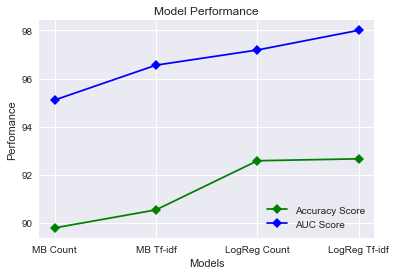

In [35]:
#Accuracy Scores
Accuracy  = [89.80,90.55,92.59,92.67]

AUC = [95.11,96.56,97.19,98.01]


xaxis = [1,2,3,4]

plt.plot(xaxis, Accuracy, marker='D', color='green', label='Accuracy Score')
plt.plot(xaxis, AUC, marker='D', color='blue', label='AUC Score')
plt.xticks(xaxis, ['MB Count', 'MB Tf-idf', 'LogReg Count', 'LogReg Tf-idf'])
plt.legend(loc='lower right')
plt.xlabel('Models')
plt.ylabel('Perfomance')
plt.title('Model Performance')
plt.show()
